In [1]:
from EDA import *
from Data_Preprocessing import *
from Models import *
from Evaluation import *
from plot_prediction import *

# Data Preprocessing

In [2]:
df = load_data('Dataset/Tasla_Stock_Updated_V2.csv')

In [3]:
df_train, df_test = split_data(df)

In [4]:
df_train=create_features(df_train)
df_test=create_features(df_test)

In [5]:
df_full = create_features(df)


In [6]:
features_to_scale = ['Low','High','Open','Close','Volume' ,'Monthly_Return', 'MA5', 'MA10', 'MA20','Volatility_5','Volatility_10','Volatility_20','Target']
df_train_scaled, df_test_scaled, fitted_scaler = scale_features(df_train, df_test, features_to_scale)
print("example of scaled data")
print(df_test_scaled.head())

example of scaled data
            Unnamed: 0      Open      High       Low     Close    Volume  \
Date                                                                       
2022-04-21        1838  0.867589  0.875241  0.814450  0.815905  0.104926   
2022-04-22        1839  0.817985  0.827925  0.812414  0.812800  0.065389   
2022-04-25        1840  0.788183  0.806292  0.796684  0.806948  0.063889   
2022-04-26        1841  0.801832  0.799183  0.712313  0.705713  0.138925   
2022-04-27        1842  0.721522  0.731554  0.714298  0.709951  0.073425   

            Monthly_Return       MA5      MA10      MA20  Volatility_5  \
Date                                                                     
2022-04-21        0.593161  0.823160  0.872942  0.928009      0.217445   
2022-04-22        0.505230  0.826560  0.868272  0.927601      0.195730   
2022-04-25        0.497180  0.825497  0.865815  0.927019      0.198433   
2022-04-26        0.216777  0.799772  0.856914  0.917098      0.599414   


# EDA

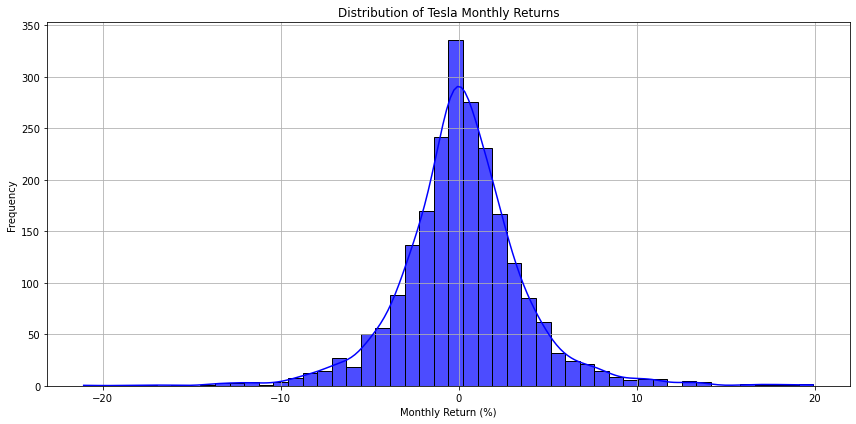

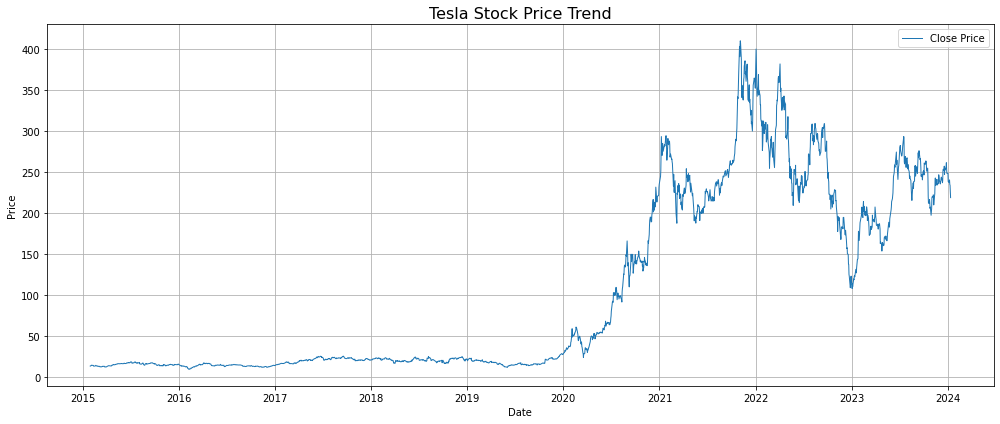

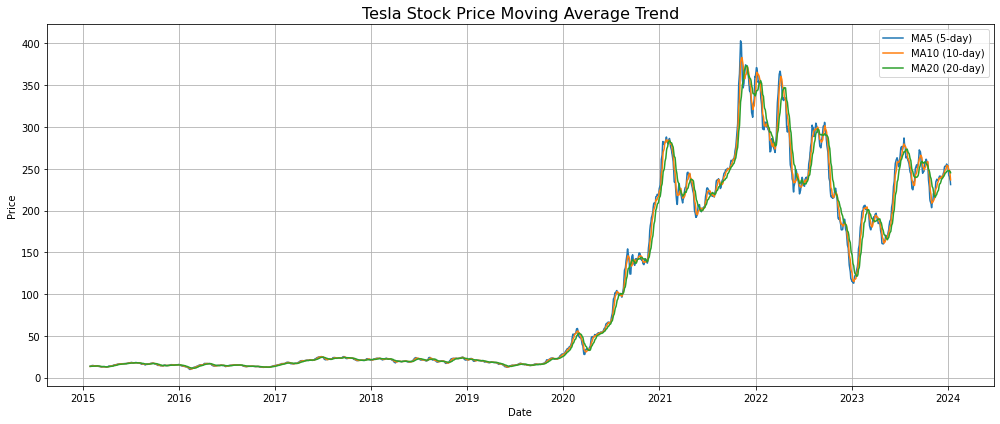

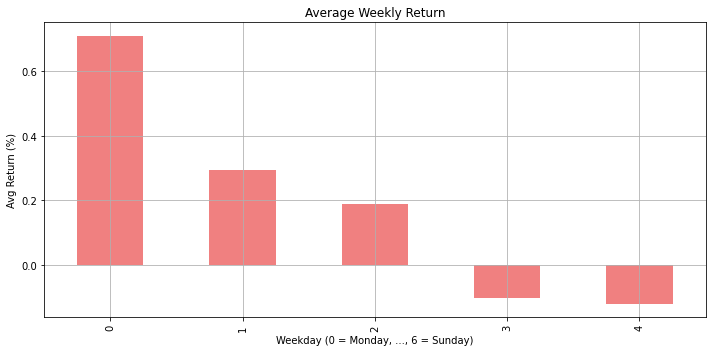

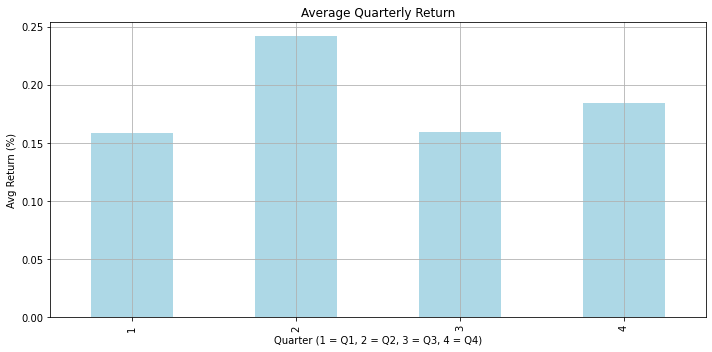

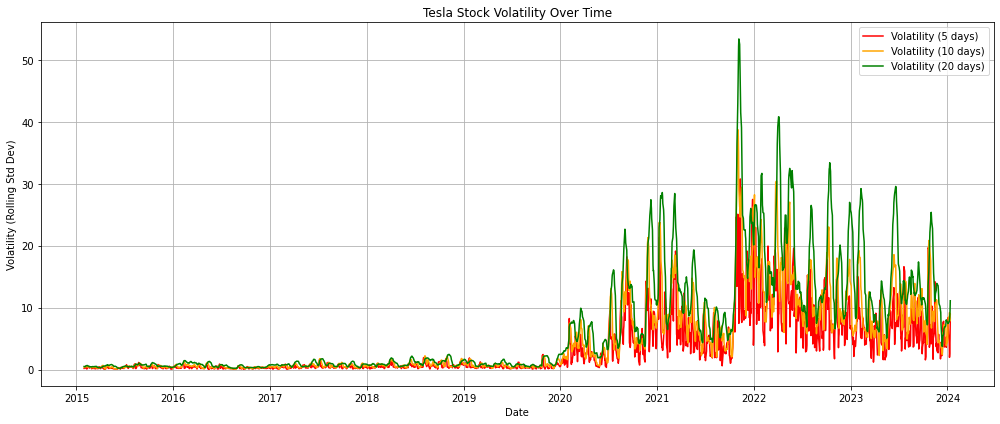

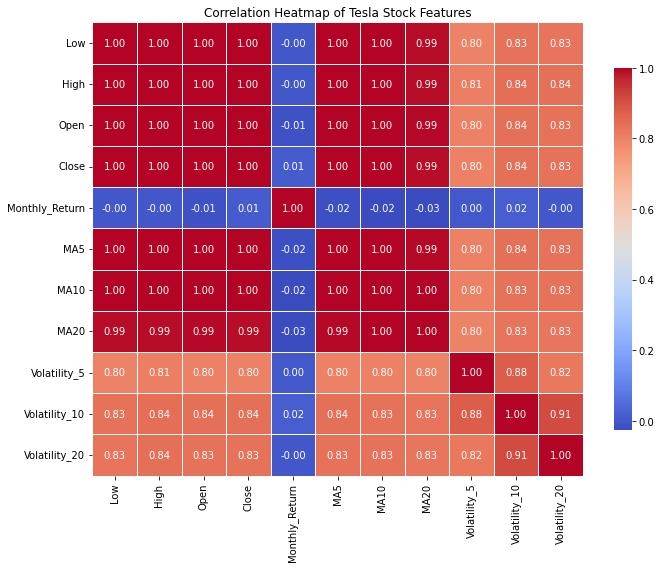

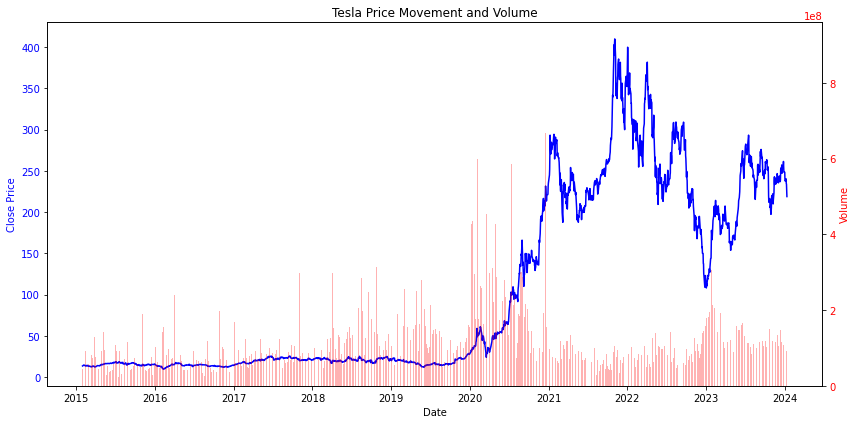

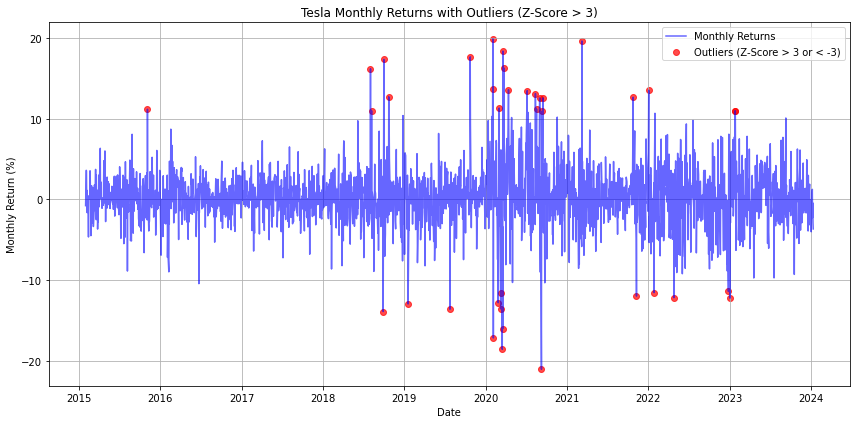

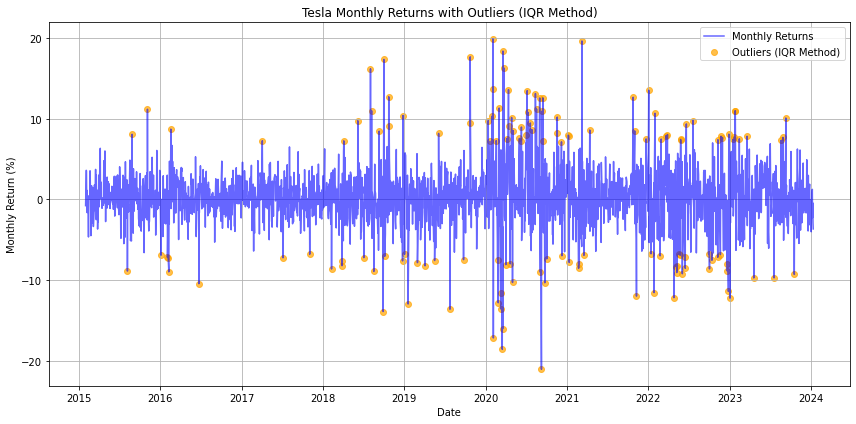

Sharpe Ratio: 0.0519


/Users/rakibabdullah/Desktop/Tesla-S/EDA.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative_Return'] = (1 + df['Daily_Return'] / 100).cumprod() - 1
/Users/rakibabdullah/Desktop/Tesla-S/EDA.py:155: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.resample('Y').last()


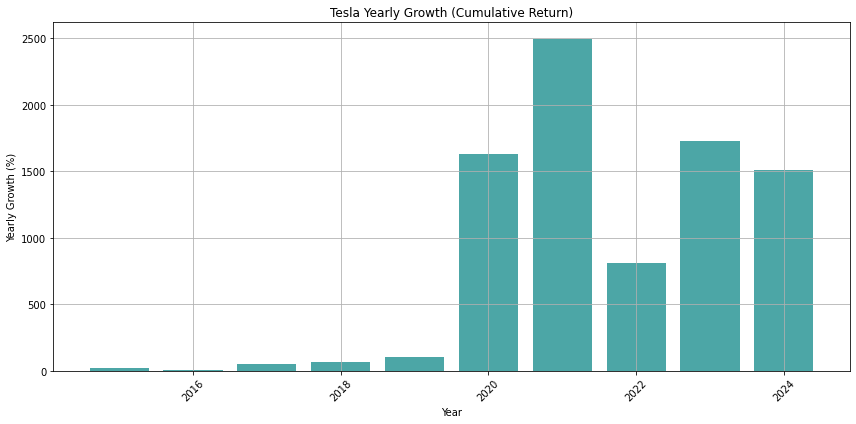

In [7]:
plot_monthly_return_distribution(df_full) # distribution of monthly returns
plot_stock_price_trend(df_full) 
plot_moving_averages(df_full) 

plot_weekly_avg_return(df_full) # weekly average return seasonality
plot_quarterly_seasonality(df_full) # quarterly seasonality

plot_volatility(df_full) #volatility over time
plot_correlation_heatmap(df_full) #correlation heatmap between features
plot_volume_vs_price(df_full) # volume vs price movement

plot_zscore_outliers(df_full) # z-score outliers
plot_iqr_outliers(df_full) 

calculate_sharpe_ratio(df_full)
plot_cumulative_returns(df_full)



In [8]:
import sys
print(sys.executable)
print(sys.version)


/usr/local/bin/python3
3.10.0 (v3.10.0:b494f5935c, Oct  4 2021, 14:59:19) [Clang 12.0.5 (clang-1205.0.22.11)]


# Model Tranining and Testing

## SMA

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0123
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0157
R-squared (R²): 0.9807
Mean Absolute Percentage Error (MAPE): 2.3518%




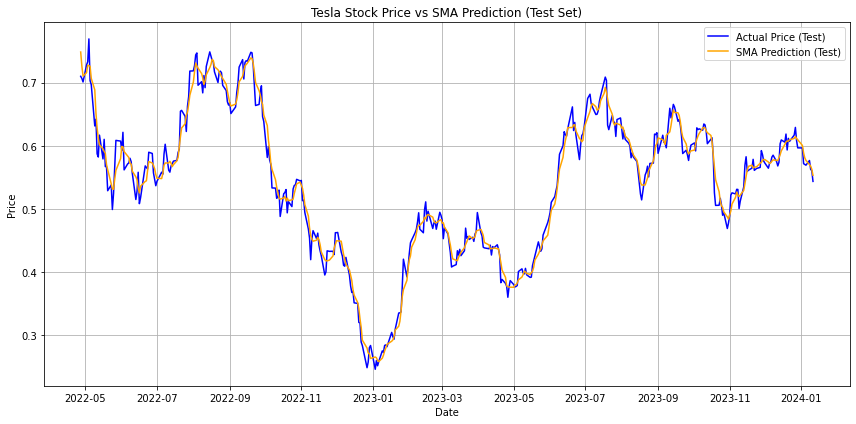

In [9]:
# Apply Simple Moving Average (SMA) to the test set
df_test_scaled['SMA_Prediction'] = simple_moving_average_model(df_test_scaled, window=5)

df_test_scaled.dropna(inplace=True)

evaluate_model(df_test_scaled['Close'], df_test_scaled['SMA_Prediction'])
plot_simple_moving_average(df_test_scaled)

## Linear Regression

In [10]:
y_test, y_pred = linear_regression_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred)  

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0153
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0204
R-squared (R²): 0.9674
Mean Absolute Percentage Error (MAPE): 2.9296%




In [11]:
volatility_period_metrics = []

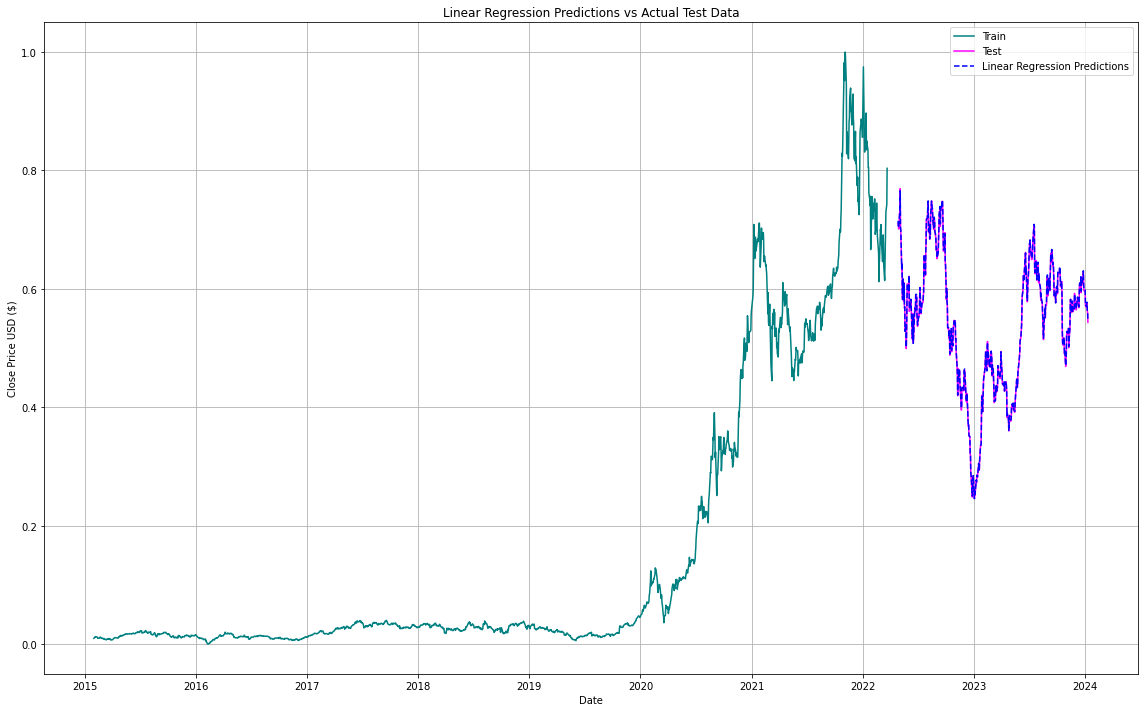

In [12]:
plot_test_train_prediction("Linear Regression",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.015309882261995223
Root Mean Squared Error (RMSE) during High Volatility: 0.020555247381435854


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


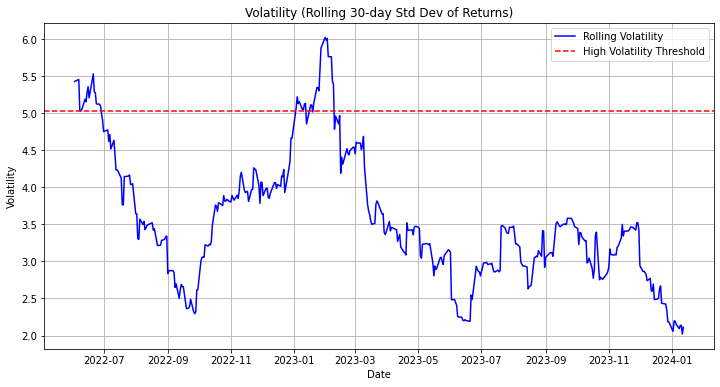

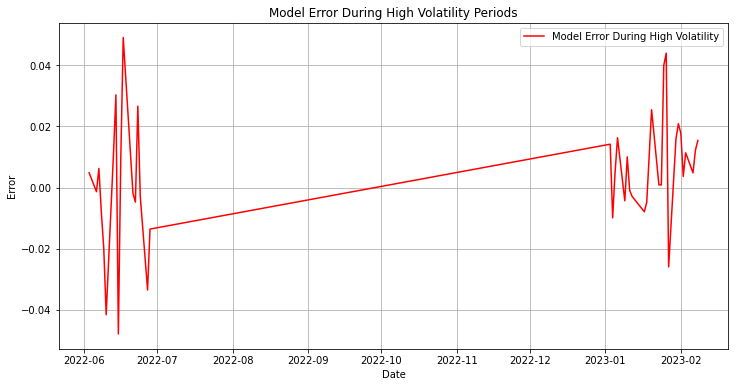

In [13]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("Linear Regression", mae_volatility, rmse_volatility))

## XGBoost

In [14]:
y_test, y_pred= xgboost_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred)

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0217
Mean Squared Error (MSE): 0.0008
Root Mean Squared Error (RMSE): 0.0278
R-squared (R²): 0.9397
Mean Absolute Percentage Error (MAPE): 4.2362%




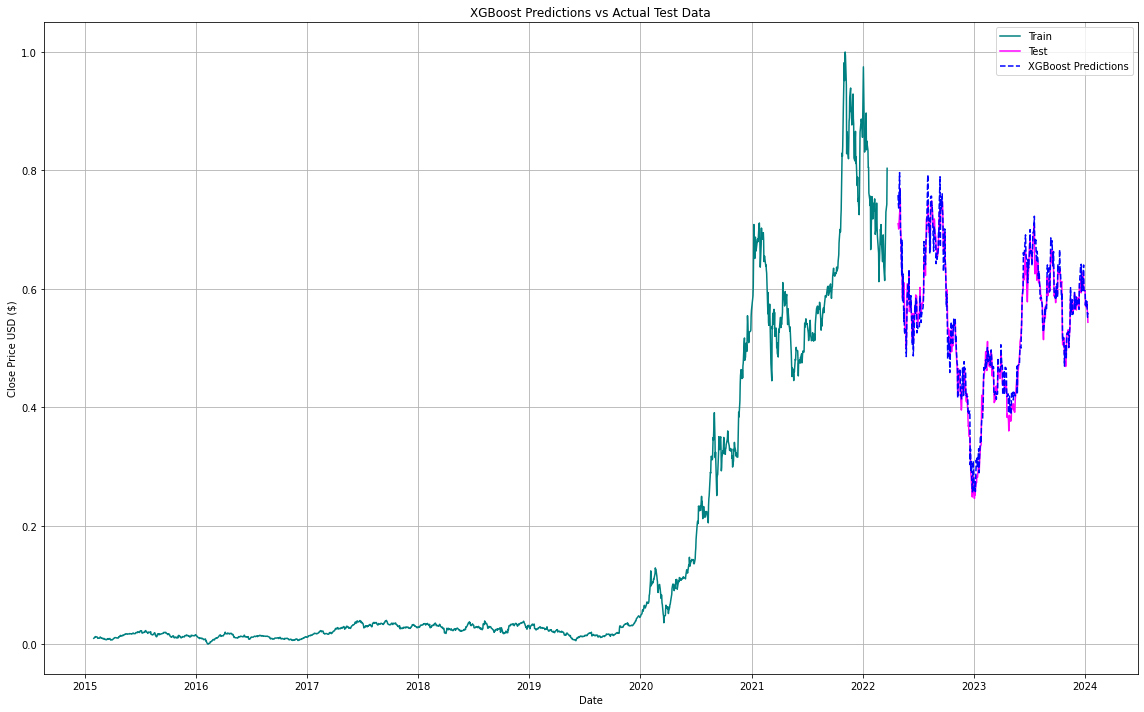

In [15]:
plot_test_train_prediction("XGBoost",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.020909474141556895
Root Mean Squared Error (RMSE) during High Volatility: 0.025450468786200896


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


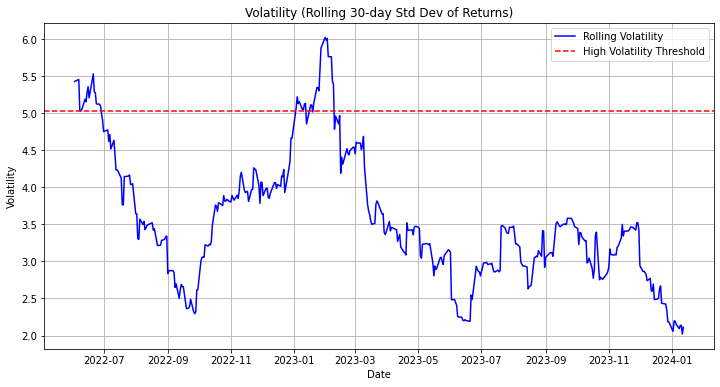

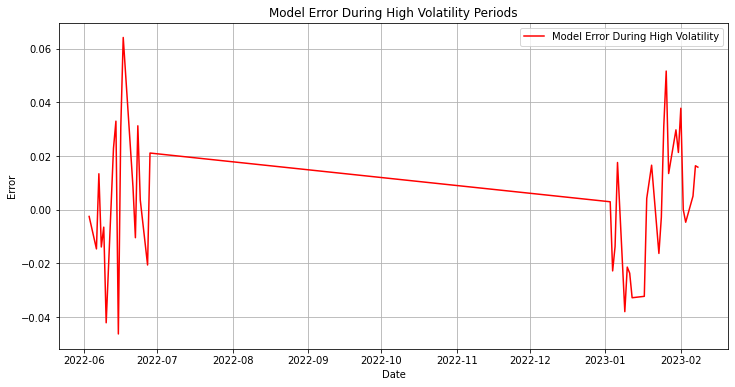

In [16]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("XgBoost", mae_volatility, rmse_volatility))

## RandomForestRegressor

In [17]:
y_test, y_pred = random_forest_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred) 

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0209
Mean Squared Error (MSE): 0.0007
Root Mean Squared Error (RMSE): 0.0270
R-squared (R²): 0.9432
Mean Absolute Percentage Error (MAPE): 4.2403%




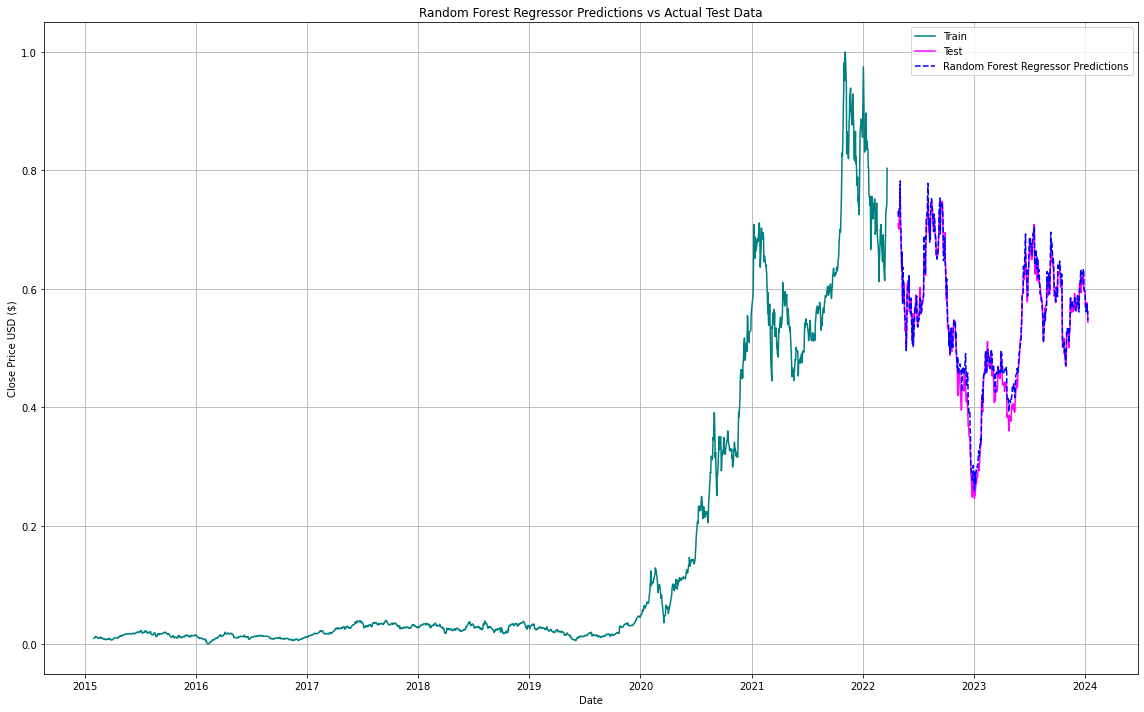

In [18]:
plot_test_train_prediction("Random Forest Regressor",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.018924793196041016
Root Mean Squared Error (RMSE) during High Volatility: 0.022731202103230475


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


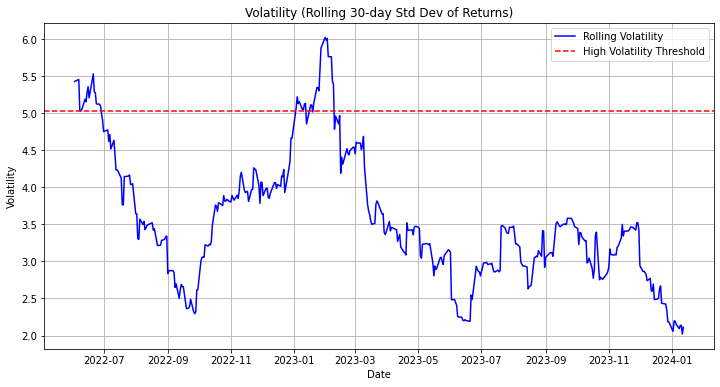

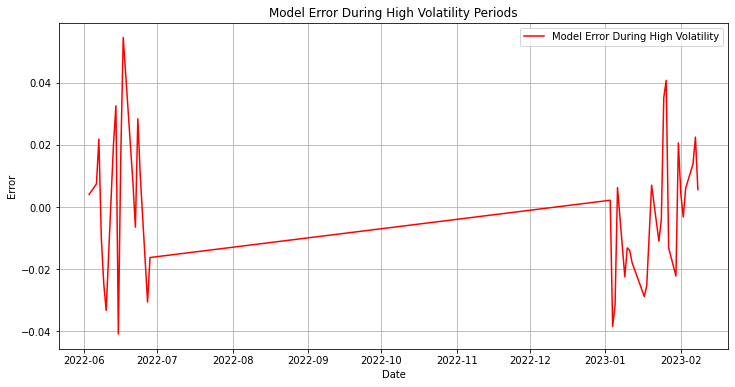

In [19]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("Random forest regressor", mae_volatility, rmse_volatility))

## SVR

In [20]:
y_test, y_pred = svr_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred) 

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0208
Mean Squared Error (MSE): 0.0007
Root Mean Squared Error (RMSE): 0.0261
R-squared (R²): 0.9466
Mean Absolute Percentage Error (MAPE): 4.1836%




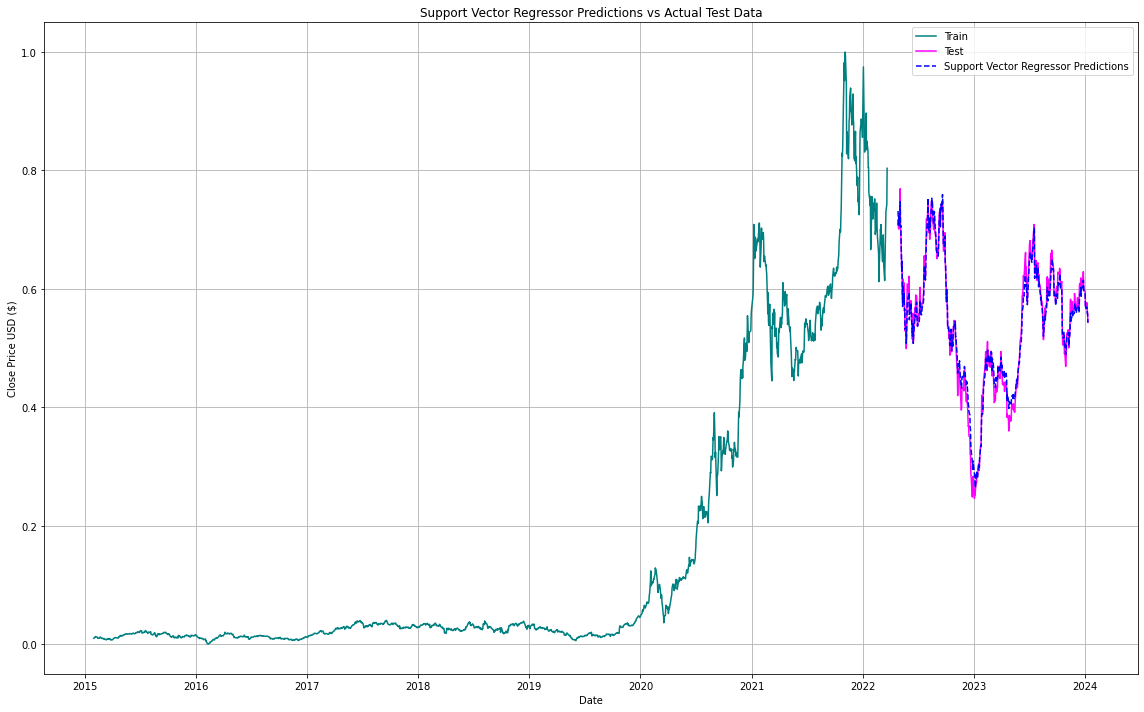

In [21]:
plot_test_train_prediction("Support Vector Regressor",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.019042302445367837
Root Mean Squared Error (RMSE) during High Volatility: 0.022928910003380952


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


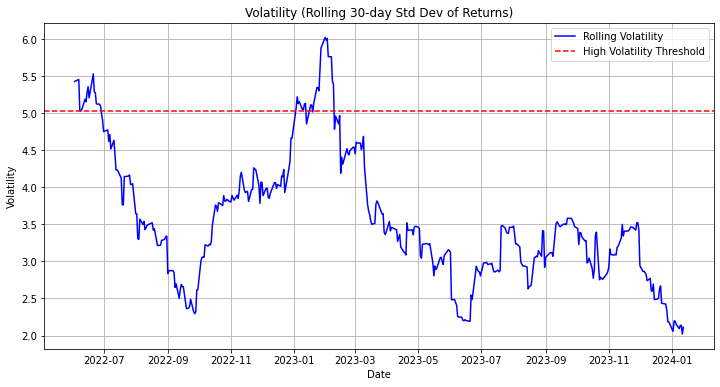

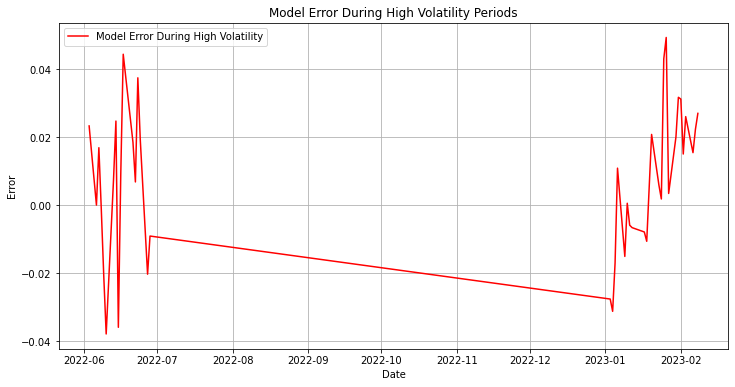

In [22]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("SVR", mae_volatility, rmse_volatility))

## DT regressor

In [23]:
y_test, y_pred = decision_tree_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred) 

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0299
Mean Squared Error (MSE): 0.0014
Root Mean Squared Error (RMSE): 0.0377
R-squared (R²): 0.8889
Mean Absolute Percentage Error (MAPE): 5.6928%




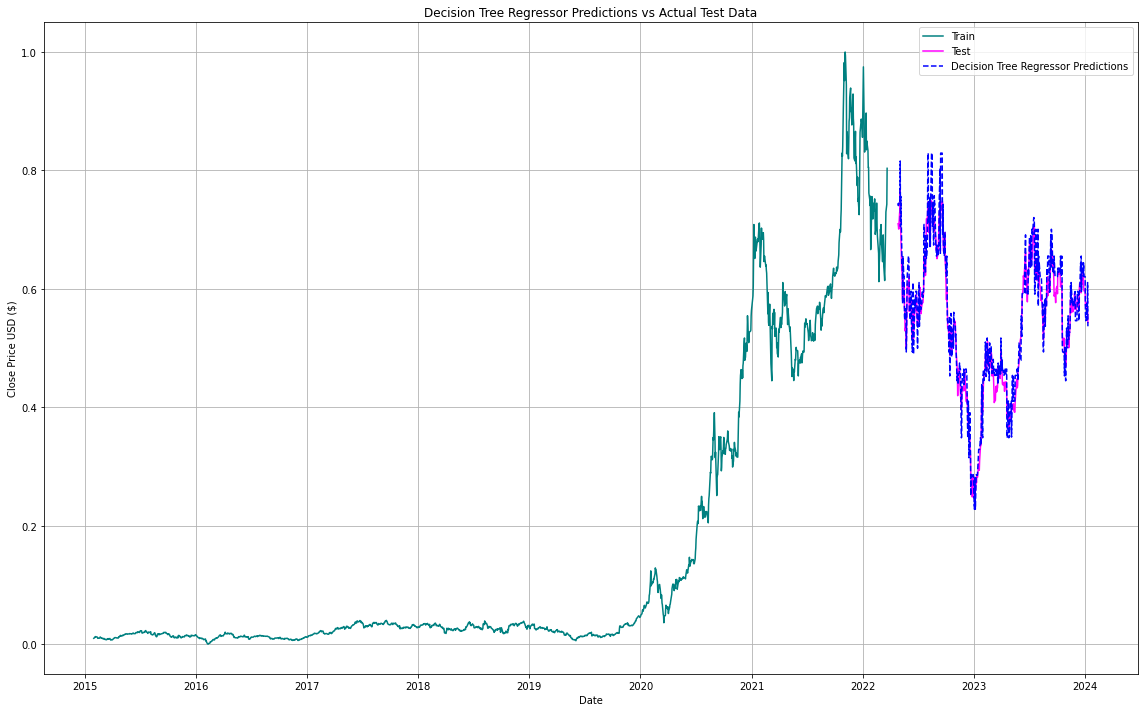

In [24]:
plot_test_train_prediction("Decision Tree Regressor",df_train_scaled, df_test_scaled, y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.025382194512731115
Root Mean Squared Error (RMSE) during High Volatility: 0.032807470230865145


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:105: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_volatility_data = df_test_scaled[df_test['High_Volatility']]


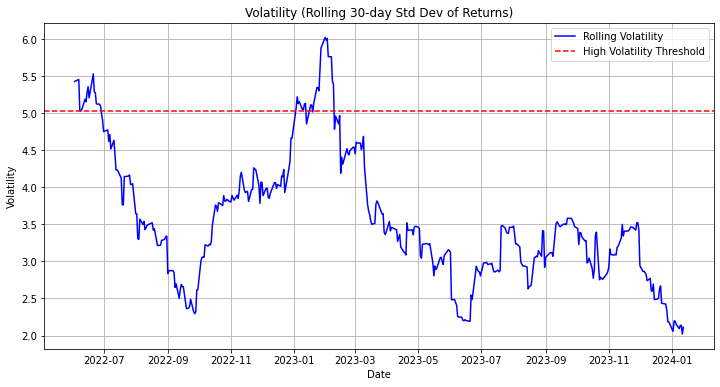

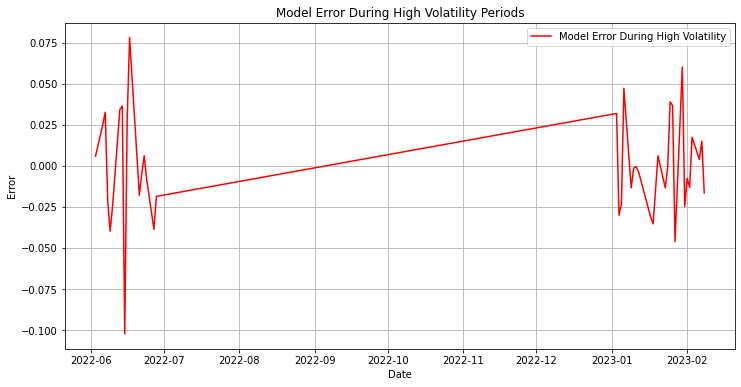

In [25]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test, df_test_scaled, y_pred)

volatility_period_metrics.append(("DT regressor", mae_volatility, rmse_volatility))

## LSTM

In [26]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU


In [28]:
from Models import *

Reloading Tuner from hyperparameter_tuning/lstm_hyperparameter_tuning/tuner0.json
Best hyperparameters: {'lstm_units_1': 150, 'dropout_1': 0.2, 'lstm_units_2': 200, 'dropout_2': 0.1, 'dense_units': 64, 'learning_rate': 0.00033612834408703365}
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0463 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5641e-04 - root_mean_squared_error: 0.0157 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6190e-05 - root_mean_squared_error: 0.0098 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1980e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1703e-04 - root_mean_squared_error: 0.0108 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0149e-04 - root_mean_squared_error: 0.0100 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

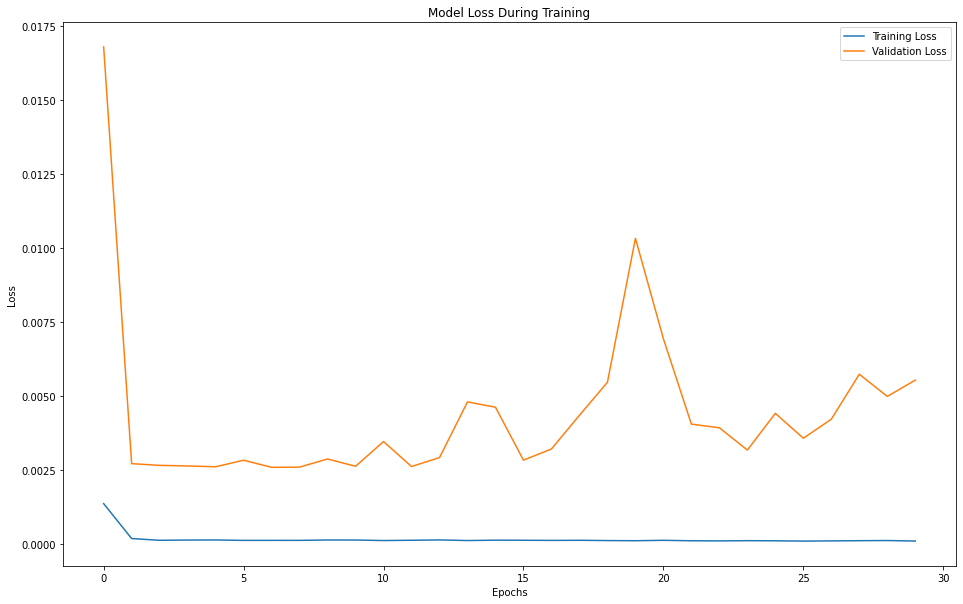

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0407
Mean Squared Error (MSE): 0.0025
Root Mean Squared Error (RMSE): 0.0503
R-squared (R²): 0.7979
Mean Absolute Percentage Error (MAPE): 23.7775%




In [29]:
y_test, y_pred = lstm_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred) 

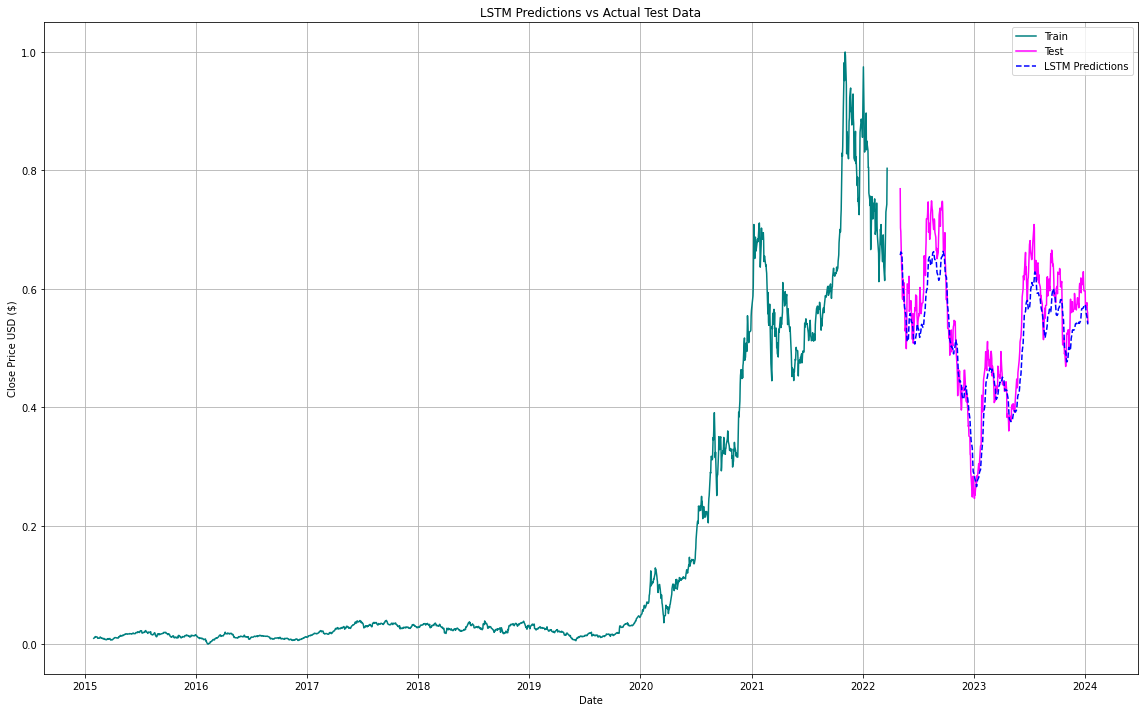

In [30]:
plot_test_train_prediction("LSTM",df_train_scaled, df_test_scaled[5:], y_pred)



Mean Absolute Error (MAE) during High Volatility: 0.04066900585577933
Root Mean Squared Error (RMSE) during High Volatility: 0.04892026413188414


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Returns'] = df_test['Close'].pct_change() * 100
/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Rolling_Volatility'] = df_test['Returns'].rolling(window=30).std()
/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

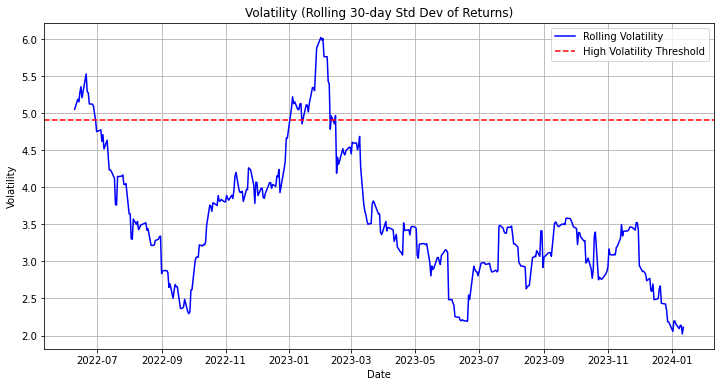

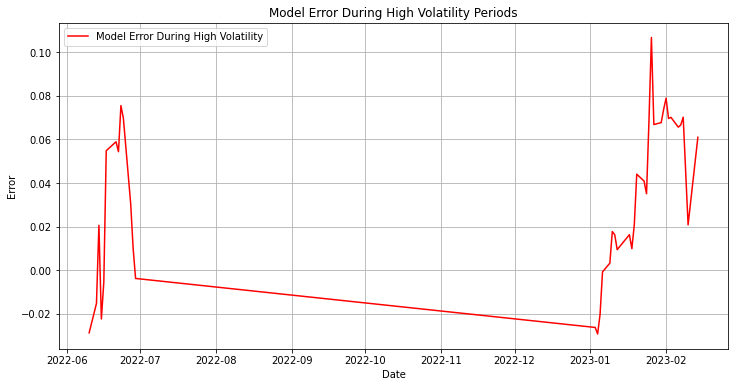

In [31]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test[5:], df_test_scaled[5:], y_pred)

volatility_period_metrics.append(("LSTM", mae_volatility, rmse_volatility))

## GRU Model

Reloading Tuner from hyperparameter_tuning_gru/gru_hyperparameter_tuning/tuner0.json
Best hyperparameters: {'gru_units_1': 150, 'dropout_1': 0.1, 'gru_units_2': 200, 'dropout_2': 0.1, 'gru_units_3': 150, 'dense_units': 96, 'dropout_3': 0.5, 'learning_rate': 8.327414044844959e-05}
Epoch 1/64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0024 - root_mean_squared_error: 0.0472 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 2/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8653e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 3/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6822e-04 - root_mean_squared_error: 0.0190 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 4/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9567e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 5/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.5328e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 6/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.3791e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 7/64
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 

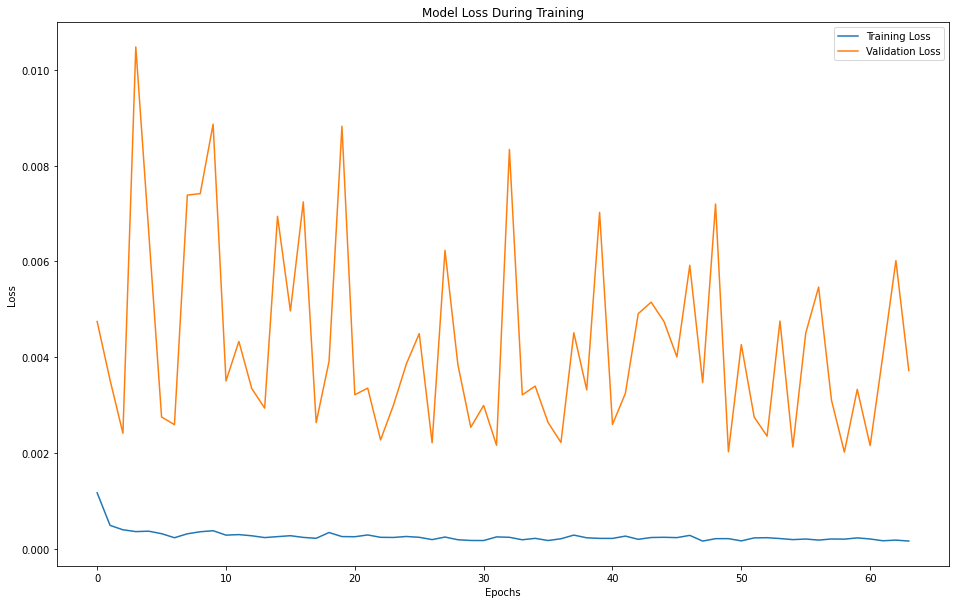

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0334
Mean Squared Error (MSE): 0.0017
Root Mean Squared Error (RMSE): 0.0416
R-squared (R²): 0.8616
Mean Absolute Percentage Error (MAPE): 26.0596%




In [32]:
y_test, y_pred = gru_model(df_train_scaled, df_test_scaled)

evaluate_model(y_test, y_pred)



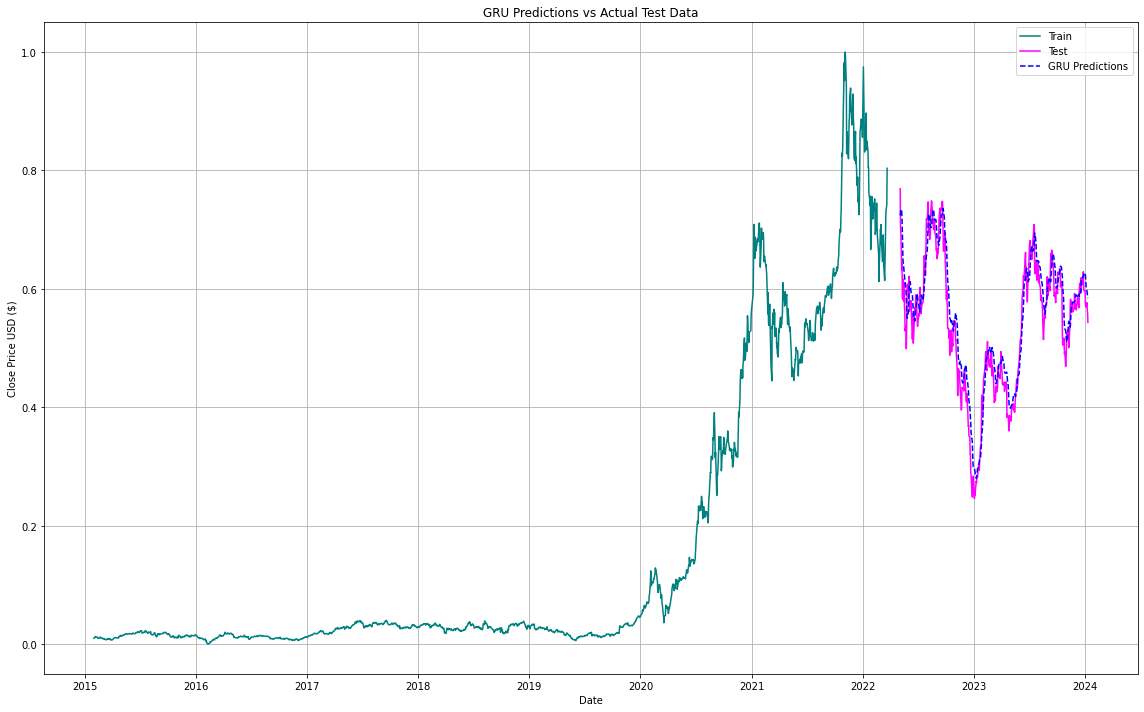

In [33]:
plot_test_train_prediction("GRU",df_train_scaled, df_test_scaled[5:], y_pred)

Mean Absolute Error (MAE) during High Volatility: 0.03015612222314759
Root Mean Squared Error (RMSE) during High Volatility: 0.036006518096600756


/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Returns'] = df_test['Close'].pct_change() * 100
/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Rolling_Volatility'] = df_test['Returns'].rolling(window=30).std()
/Users/rakibabdullah/Desktop/Tesla-S/Evaluation.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

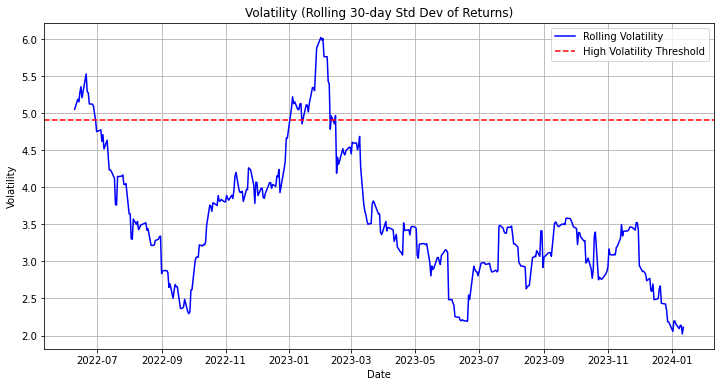

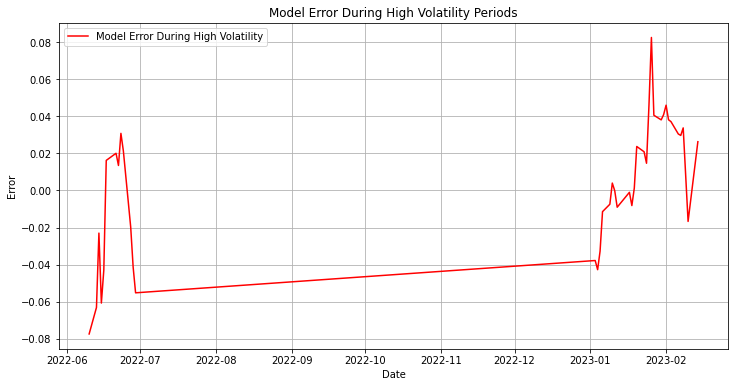

In [34]:
mae_volatility,rmse_volatility=volatility_error_plot(df_test[5:], df_test_scaled[5:], y_pred)

volatility_period_metrics.append(("GRU", mae_volatility, rmse_volatility))

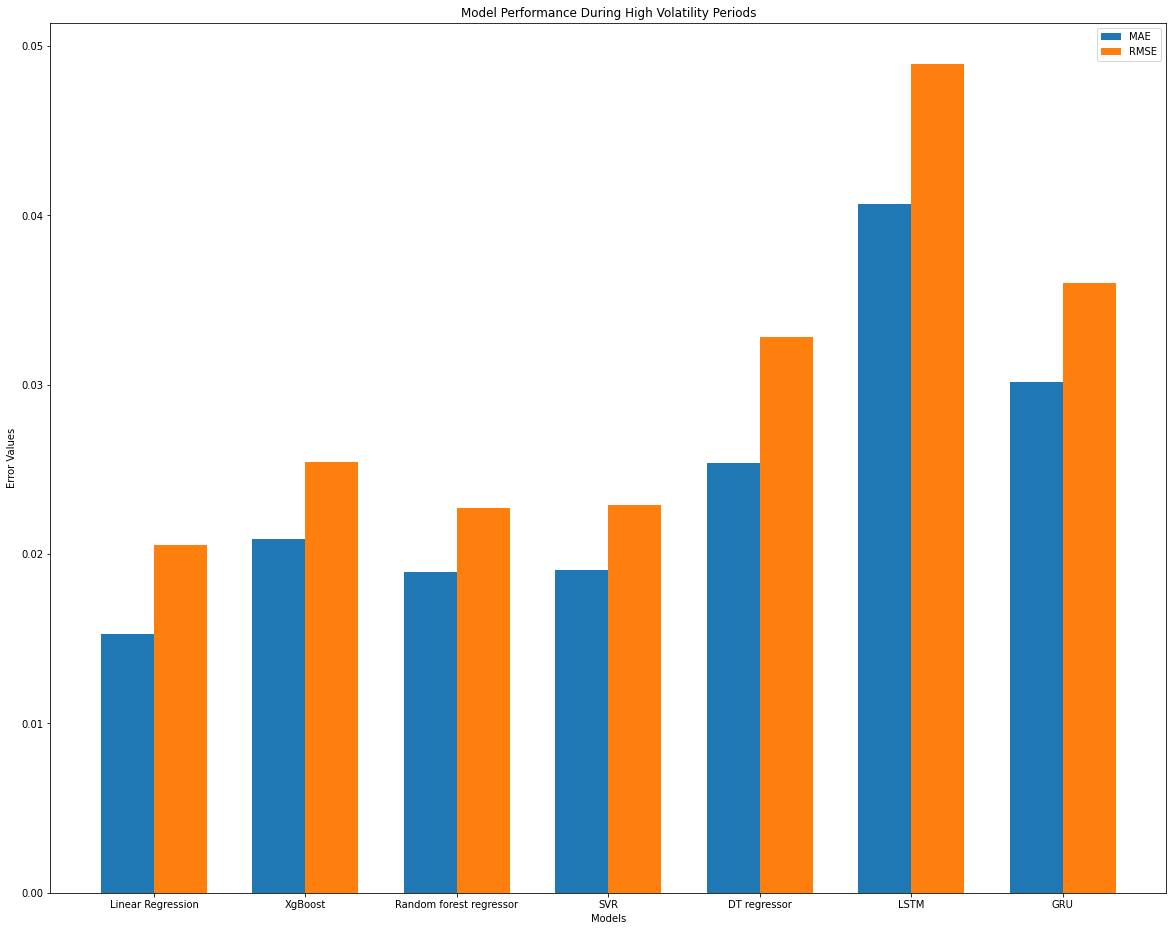

In [35]:
# Separate model names, MAE, and RMSE values
models = [model for model, _, _ in volatility_period_metrics]
mae_values = [mae for _, mae, _ in volatility_period_metrics]
rmse_values = [rmse for _, _, rmse in volatility_period_metrics]

# Plot comparison of MAE and RMSE for different models
x = np.arange(len(models))  # Model index

fig, ax = plt.subplots(figsize=(20, 16))
width = 0.35  # Bar width

# Plotting both MAE and RMSE side by side
bar1 = ax.bar(x - width/2, mae_values, width, label='MAE')
bar2 = ax.bar(x + width/2, rmse_values, width, label='RMSE')

ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('Model Performance During High Volatility Periods')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


In [43]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

def walk_forward_validation(df, model_func, feature_cols, target_col='Target', start=100, step=1):
    """
    Perform walk-forward validation.

    Parameters:
        df: DataFrame containing all features and target
        model_func: function that returns a fitted model (e.g., LinearRegression)
        feature_cols: list of feature column names
        target_col: name of the target column
        start: number of initial samples to train on
        step: how many steps ahead to predict (default 1)

    Returns:
        y_true: list of actual values
        y_pred: list of predicted values
    """
    y_true, y_pred = [], []

    for i in range(start, len(df) - step):
        train_data = df.iloc[:i]
        test_data = df.iloc[i:i+step]

        X_train = train_data[feature_cols]
        y_train = train_data[target_col]

        X_test = test_data[feature_cols]
        y_test = test_data[target_col]

        # Train model
        model = model_func()
        model.fit(X_train, y_train)

        # Predict
        pred = model.predict(X_test)

        y_true.extend(y_test.values)
        y_pred.extend(pred.flatten())

    return y_true, y_pred

In [44]:
feature_cols = ['Low', 'High', 'Open', 'Close', 'Volume', 'Monthly_Return', 'MA5', 'MA10', 'MA20']

# List of models with their names
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Support Vector Regressor", SVR(kernel='rbf', C=100, epsilon=0.1)),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("XGBoost", xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
]

for name,model_instance in models:
    print(f"Running Walk-Forward Validation for: {name}")
    y_true, y_pred = walk_forward_validation(df_test_scaled, 
                                         model_func=lambda m=model_instance: m, 
                                         feature_cols=feature_cols,
                                         start=100)
    # Evaluate model performance
    evaluate_model(y_true, y_pred)

Running Walk-Forward Validation for: Linear Regression
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0144
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0193
R-squared (R²): 0.9669
Mean Absolute Percentage Error (MAPE): 2.9600%


Running Walk-Forward Validation for: Random Forest
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0167
Mean Squared Error (MSE): 0.0005
Root Mean Squared Error (RMSE): 0.0219
R-squared (R²): 0.9573
Mean Absolute Percentage Error (MAPE): 3.4959%


Running Walk-Forward Validation for: Support Vector Regressor
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0366
Mean Squared Error (MSE): 0.0023
Root Mean Squared Error (RMSE): 0.0482
R-squared (R²): 0.7942
Mean Absolute Percentage Error (MAPE): 8.1926%


Running Walk-Forward Validation for: Decision Tree
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0223
Mean Squared Error (MSE): 0.0008
Root Mean Squared Error (RMSE): 0.0286
R-squared (R²): 0.9275
Mean Absolute 